# Distributed Memory
> Random Features enable Dense Associative Memory to store patterns in a distributed manner across a large number of neurons.

:::{.callout-warning}
## Under Construction
:::

In [1]:
#| hide
import jax
import jax.numpy as jnp
from jaxtyping import Float, Array, PyTree, jaxtyped, UInt, Bool
import jax.random as jr
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from typing import *

In [2]:
def sin_cos_phi(x: Float[Array, "... D"], RF:Float[Array, "Y D"], beta: float) -> Float[Array, "... 2Y"]:
    """The reigning champion, a basis function that uses sin and cos to encode the input into the feature space. """
    Y = RF.shape[0]
    h = jnp.sqrt(beta) * (x @ RF.T)
    return 1 / jnp.sqrt(Y) * jnp.concatenate( [ jnp.cos(h), jnp.sin(h)], axis=-1)

In [3]:
class DrDAM:
    """Defines the interface and basic methods for all KernelizableDAMs"""
    def __init__(self, key, D, Y, beta):
        self.RF = jr.normal(key, (Y, D))
        self.beta = beta
        self.Y = Y
        self.Tdim = 2*Y
        self.D = D

    def phi(self, x: Float[Array, "... D"]) -> Float[Array, "... 2Y"]:
        """Compute the basis function """
        return sin_cos_phi(x, self.RF, self.beta)

    def sim(self, x: Float[Array, "D"], y: Float[Array, "D"]) -> Float[Array, ""]:
        """Compute the standard L2 similarity between two vectors."""
        return jnp.exp(-self.beta / 2 * ((x - y) ** 2).sum())

    def energy(
        self, x: Float[Array, "D"], memories: Float[Array, "M D"]
    ) -> Float[Array, ""]:
        """Compute the standard L2 energy"""
        return -(1 / self.beta) * jax.nn.logsumexp(
            -self.beta / 2 * ((x - memories) ** 2).sum(-1), axis=0
        )

    def kernel_energy(
        self, x: Float[Array, "D"], T: Float[Array, "2Y"], eps=1e-10
    ) -> Float[Array, ""]:
        """Compute the approximate kernelized energy"""
        h = self.phi(x) @ T 
        h = jnp.clip(h,  a_min=eps)
        return -(1 / self.beta) * jnp.log(h)
    
    def kernel_sim(
        self, x: Float[Array, "D"], y: Float[Array, "D"]
    ) -> Float[Array, ""]:
        """Compute the approximate kernel similarity of `x` and `y`"""
        return self.phi(x) @ self.phi(y)

    def kernelize_memories(self, memories: Float[Array, "M D"], **kwargs) -> Float[Array, "2Y"]:
        """
        Naive implementation that BLOWS UP with many memories `n`,
        since it creates the entire memory matrix from scratch
        """
        return self.phi(memories).sum(0)

    def recall( 
        self, q: Float[Array, "D"], memories: Float[Array, "M D"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False, 
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the normal similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.energy))
        logs = {}
        def step(x, i):
            E, dEdx = dEdxf(x, memories)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

    def kernel_recall(
        self, q: Float[Array, "D"], T: Float[Array, "2Y"], 
        depth: int=1000, alpha: float = 0.1, return_grads=False,
        clamp_idxs: Optional[Bool[Array, "D"]]=None
    ) -> Float[Array, "D"]: 
        """Using the kernelized similarity function, run energy dynamics"""
        dEdxf = jax.jit(jax.value_and_grad(self.kernel_energy))
        logs = {}
        @jax.jit
        def step(x, i):
            E, dEdx = dEdxf(x, T)
            if clamp_idxs is not None:
                dEdx = jnp.where(clamp_idxs, 0, dEdx)
            x = x - alpha * dEdx
            aux = (E, dEdx) if return_grads else (E,)
            return x, aux
        x, aux = jax.lax.scan(step, q, jnp.arange(depth))
        logs['energies'] = aux[0]
        if return_grads:
            logs['grads'] = aux[1]
        return x, logs

In [4]:
rng = jr.PRNGKey(0)
k1, k2, k3, k4, k5, rng = jr.split(rng, 6)
D = 10
Y = 100
n_memories = 20
n_queries = 100
beta = 10
kdam = DrDAM(k1, D=D, Y=Y, beta=beta)

In [5]:
x = (jr.uniform(k2, (D,)) > 0.5) / jnp.sqrt(D)
y = (jr.uniform(k3, (D,)) > 0.5) / jnp.sqrt(D)
print(x.shape)
print(y.shape)

(10,)
(10,)


In [6]:
print(kdam.sim(x, y))
print(kdam.kernel_sim(x, y))

0.011108992
0.006203072


In [7]:
memories = (jr.uniform(k4, (n_memories, D)) > 0.5) / jnp.sqrt(D)
queries = (jr.uniform(k5, (n_queries, D)) > 0.5) / jnp.sqrt(D)
print(queries.shape, memories.shape)
T = kdam.kernelize_memories(memories)
print(T.shape)

(100, 10) (20, 10)
(200,)


In [8]:
print(kdam.energy(x, memories))
print(kdam.kernel_energy(x, T))

-0.07309916
-0.08676291


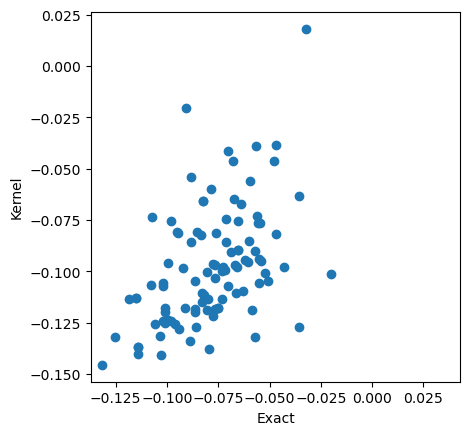

In [9]:
exact_energies = jnp.array([kdam.energy(q, memories).item() for q in queries])
kernelized_energies = kdam.kernel_energy(queries, T)
plt.scatter(exact_energies, kernelized_energies)
plt.xlabel("Exact")
plt.ylabel("Kernel")
plt.axis('square')
# plt.gca().set_aspect('equal', 'box')
plt.show()

In [10]:
exact_out, _ = kdam.recall(queries[0], memories, depth=100, alpha=1)
kernel_out, _ = kdam.kernel_recall(queries[0], T, depth=100, alpha=1)
print(jnp.abs(exact_out - kernel_out).sum())

0.13190839
